# CNN version Laser Machine Listener: Preprocess

Run `download.sh` before starting this, to download dataset.

In [1]:
import sys
sys.path.append('../..')
from lib_train import *
%matplotlib inline

{'sampling_rate': 16000, 'duration': 1, 'hop_length': 253, 'fmin': 20, 'fmax': 8000, 'n_mels': 64, 'n_fft': 1280, 'labels': ['background', 'cutting_in_focus', 'cutting_not_in_focus', 'marking', 'sleeping', 'waiting'], 'folder': PosixPath('.'), 'n_fold': 1, 'normalize': 'samplewise', 'valid_limit': None, 'random_state': 42, 'samples_per_file': 30, 'test_size': 0.2, 'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 50, 'verbose': 2, 'best_weight_file': 'best_model_weight.h5', 'eval_ensemble': False, 'rt_process_count': 1, 'rt_oversamples': 10, 'pred_ensembles': 10, 'runtime_model_file': 'cnn-model-laser-machine-listener.pb', 'label2int': {'background': 0, 'cutting_in_focus': 1, 'cutting_not_in_focus': 2, 'marking': 3, 'sleeping': 4, 'waiting': 5}, 'num_classes': 6, 'samples': 16000, 'rt_chunk_samples': 1600, 'mels_onestep_samples': 1600, 'mels_convert_samples': 17600, 'dims': [64, 64, 1], 'model': 'mobilenetv2', 'metric_save_ckpt': 'val_loss', 'metric_save_mode': 'auto', 'logdir': 'lo

Using TensorFlow backend.


## Make a list of training samples

As listed below, this dataset is quite small:

- 6 classes
- 12 audio samples

And this dataset is following basic structure of Keras classification project; `yourdataset/classname/filename.wav`.

In [3]:
DATAROOT = Path('laser-machine-listener/data')
data_files = list(DATAROOT.glob('*/*.wav'))
data_files

[PosixPath('laser-machine-listener/data/sleeping/sleeping.wav'),
 PosixPath('laser-machine-listener/data/background/background.wav'),
 PosixPath('laser-machine-listener/data/marking/acrylic_marking.wav'),
 PosixPath('laser-machine-listener/data/marking/paper_marking.wav'),
 PosixPath('laser-machine-listener/data/marking/mdf_marking.wav'),
 PosixPath('laser-machine-listener/data/waiting/waiting.wav'),
 PosixPath('laser-machine-listener/data/cutting_not_in_focus/paper_cutting_not_in_focus.wav'),
 PosixPath('laser-machine-listener/data/cutting_not_in_focus/mdf_cutting_not_in_focus.wav'),
 PosixPath('laser-machine-listener/data/cutting_not_in_focus/acrylic_cutting_not_in_focus.wav'),
 PosixPath('laser-machine-listener/data/cutting_in_focus/acrylic_cutting_in_focus.wav'),
 PosixPath('laser-machine-listener/data/cutting_in_focus/mdf_cutting_in_focus.wav'),
 PosixPath('laser-machine-listener/data/cutting_in_focus/paper_cutting_in_focus.wav')]

## Preprocess

Data preprocessing follows these steps:

1. `mels_build_multiplexed_X()` converts `classname/filename.wav` style raw audio as log mel-spectrogram, generate training data samples. Output is multiplexed training set denoted by XX.
2. The multiplexed set is once flattened to normal training set (usually denoted by X), then divided into train/test split.
3. Save as files.

In this case, there are only 12 original audio samples. Then 288 training & 72 validation samples are created.

- One sample duration is 1 second which is defined by config.py as conf.duration.
- One sample is a three dimentional, [64 n_mels, 64 time hops, 1 channel] vector.

### This preprocessing intentionally leaks data

Usually train/test split shall be very clean, test set is supposed be 'unseen'.

But this data set is a special case, all classes has only one sample from sound variations.
Even though some class have 3 samples but these are ones from all different variations.

Then there's no way collecting train/test samples from different audio files. The step 3 above shuffles data.

In [4]:
# 1. generate XX and y
XX = mels_build_multiplexed_X(conf, data_files)
y, _, _ = generate_y_from_pathname(data_files)

# 2. flatten (= unseen data is not available) & shuffle by train_test_split
X, y = mels_demux_XX_y(XX, y) # demultiplex = flatten
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=conf.test_size, random_state=conf.random_state)

# 3. write all sets as files
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

print('Training set has {} samples. X shape is {}'.format(len(X_train), X_train.shape))
print('Test set has {} samples. X shape is {}'.format(len(X_test), X_test.shape))

Set labels to config.py; conf.labels = ['background', 'cutting_in_focus', 'cutting_not_in_focus', 'marking', 'sleeping', 'waiting']
Training set has 288 samples. X shape is (288, 64, 64, 1)
Test set has 72 samples. X shape is (72, 64, 64, 1)


### Look inside

In [5]:
[a.shape for a in [XX, y, X_train, X_test, y_train, y_test]]

[(12, 30, 64, 64, 1), (360,), (288, 64, 64, 1), (72, 64, 64, 1), (288,), (72,)]

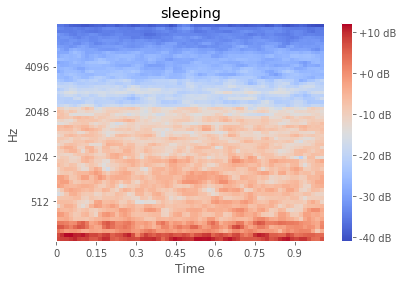

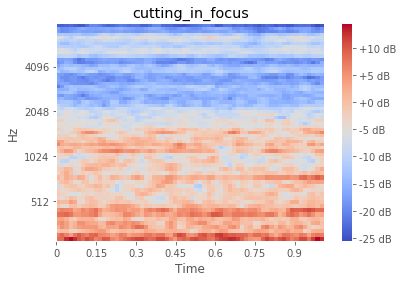

In [6]:
show_melspectrogram(conf, XX[0, 0, :, :, -1], title=conf.labels[y[0]])
show_melspectrogram(conf, X_train[0, :, :, -1], title=conf.labels[y_train[0]])

In [7]:
y_train

array([1, 1, 2, 3, 2, 1, 4, 3, 3, 4, 2, 5, 1, 1, 5, 5, 3, 1, 3, 3, 2, 3,
       2, 2, 4, 3, 4, 3, 1, 2, 2, 3, 5, 2, 1, 2, 5, 2, 5, 2, 4, 1, 3, 5,
       4, 1, 3, 1, 3, 0, 0, 5, 2, 1, 1, 2, 2, 0, 3, 1, 4, 2, 1, 4, 5, 3,
       3, 5, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 1, 3, 2, 3, 4, 0, 3, 3, 3, 1,
       1, 1, 5, 3, 3, 1, 3, 1, 5, 1, 5, 1, 2, 2, 2, 2, 3, 0, 4, 2, 1, 3,
       5, 2, 2, 3, 1, 1, 1, 1, 5, 2, 2, 5, 2, 4, 3, 2, 2, 2, 3, 1, 2, 1,
       3, 3, 1, 4, 3, 1, 3, 1, 2, 3, 2, 1, 0, 1, 3, 2, 3, 2, 3, 5, 4, 0,
       4, 5, 3, 5, 2, 2, 3, 1, 0, 1, 3, 1, 5, 2, 3, 0, 3, 1, 2, 3, 4, 1,
       3, 2, 1, 4, 4, 1, 1, 1, 3, 2, 1, 2, 5, 3, 2, 3, 0, 0, 2, 1, 4, 1,
       2, 2, 5, 1, 3, 3, 3, 3, 4, 3, 4, 5, 0, 1, 1, 2, 1, 1, 2, 2, 2, 1,
       2, 1, 1, 2, 2, 5, 0, 2, 2, 2, 3, 0, 4, 0, 3, 2, 0, 2, 3, 0, 2, 2,
       4, 1, 3, 1, 5, 1, 3, 1, 1, 1, 2, 0, 0, 5, 2, 1, 2, 5, 0, 0, 2, 2,
       4, 1, 5, 1, 2, 1, 2, 1, 3, 3, 5, 3, 3, 1, 2, 3, 1, 4, 2, 3, 3, 1,
       1, 3])

In [8]:
y_test

array([2, 0, 1, 1, 0, 1, 4, 0, 2, 3, 3, 1, 2, 1, 3, 3, 2, 1, 3, 1, 3, 2,
       1, 0, 1, 2, 3, 1, 4, 3, 2, 4, 1, 3, 3, 0, 4, 1, 3, 3, 2, 0, 1, 3,
       5, 2, 0, 4, 0, 1, 1, 2, 2, 3, 1, 1, 4, 3, 3, 1, 3, 0, 2, 3, 3, 3,
       1, 2, 1, 3, 2, 2])